# Comparisson of GMM with full covariance with implemented models
This notebooks load three different datasets, '8gaussians', 'checkerboard', and '2spirals', from the FFJORD toy datasets. 

These are then trained on the following three models:

- GMM with ful covariance (sklearn version)
- CP-decomposition model
- Tensor Train model

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

sys.path.append('../')
import utils as utl
import datasets as d
import models as m

tfd = tfp.distributions
tfm = tf.math

%load_ext autoreload
%autoreload 2

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\sap98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load training data
Load and display the 8gaussians, checkerboard and 2spirals datasets.

In [2]:
# generate toy data
N = 10000
data_1 = d.get_ffjord_data('8gaussians', batch_size=N)
data_2 = d.get_ffjord_data('checkerboard', batch_size=N)
data_3 = d.get_ffjord_data('2spirals', batch_size=N)

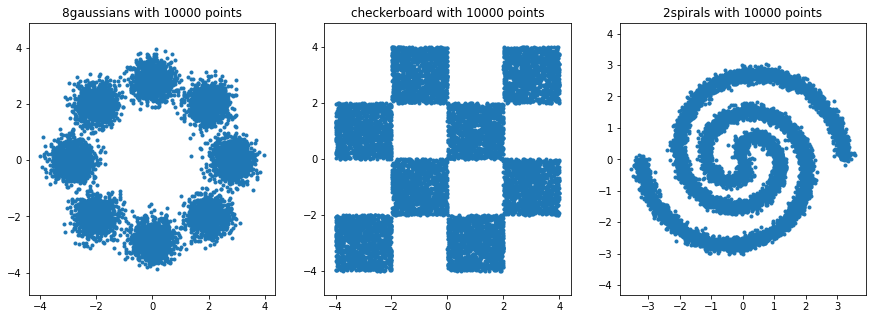

In [3]:
# Display the datasets
f,ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].plot(data_1[:, 0], data_1[:, 1], '.')
ax[0].axis('equal')
ax[0].set_title(f'8gaussians with {N} points')

ax[1].plot(data_2[:, 0], data_2[:, 1], '.')
ax[1].axis('equal')
ax[1].set_title(f'checkerboard with {N} points')

ax[2].plot(data_3[:, 0], data_3[:, 1], '.')
ax[2].axis('equal')
ax[2].set_title(f'2spirals with {N} points')

plt.show()

In [4]:
# Turn into TF batched datasets
batch_size = 200
ds_1 = d.to_tf_dataset(data_1, batch_size=batch_size)
ds_2 = d.to_tf_dataset(data_2, batch_size=batch_size)
ds_3 = d.to_tf_dataset(data_3, batch_size=batch_size)

## Define some fair Ks
Generated by use of the Fair Parameter Selection notebook.

In [5]:
K_TT = 10
K_CP = 82
K_GMM = 59

## Fit models to the 8gaussians data

In [6]:
# Training parameters
M = 2
EPOCHS = 250

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [7]:
# Instantiate models
# model_gmm_1 = GaussianMixture(
#     n_components=K_GMM, covariance_type='full', n_init=20, 
#     tol=1e-5, reg_covar=1e-6, max_iter = 400, init_params='random'
# )
model_gmm_1_km = GaussianMixture(
    n_components=K_GMM, covariance_type='full', n_init=20, 
    tol=1e-5, reg_covar=1e-6, max_iter = 400, init_params='kmeans'
)
model_cp_1 = m.CPGaussian(K_CP, M)
model_tt_1 = m.TensorTrainGaussian(K_TT, M)

In [8]:
# fit models to the 8gaussians data
# model_gmm_1.fit(data_1)
model_gmm_1_km.fit(data_1)
losses_CP = model_cp_1.fit(ds_1, EPOCHS, optimizer, 'random', tolerance=0)
losses_TT = model_tt_1.fit(ds_1, EPOCHS, optimizer, tolerance=0)

Training TT: 100%|██████████| 250/250 [01:04<00:00,  3.86it/s]


In [ ]:
# Plot learning curves for CP and TT
f,ax = plt.subplots(figsize=(12, 5))
ax.plot(losses_CP)
ax.plot(losses_TT)
ax.set_xlabel('Iteration')
ax.set_title('Negative log-likelihood')
ax.legend(['CP-decomposition','Tensor Train model'])
ax.grid('on')
plt.show()

## Inspect results of 8gaussians fit

In [ ]:
# plotting options
limit = 4
alpha = 0.1
n_points = 1000

In [ ]:
f,ax = plt.subplots(1, 3, figsize=(16, 5))

# plot for GMM
x, _ = np.linspace(-limit, limit, n_points, retstep=True)
y, _ = np.linspace(-limit, limit, n_points, retstep=True)
x_grid, y_grid = np.meshgrid(x, y) 
X = np.array([x_grid.ravel(), y_grid.ravel()]).T
p_log = model_gmm_1.score_samples(X)
p = np.exp(p_log)

ax[0].plot(data_1[:, 0], data_1[:, 1], '.', alpha=alpha)
ax[0].contour(x_grid, y_grid, p.reshape(n_points, n_points))
ax[0].axis('equal')
ax[0].set_title('GMM full cov')
ax[0].set_ylim([-4, 4])

# plot for CP
utl.plot_contours(ax[1], data_1, model_cp_1, alpha=alpha)
ax[1].set_title('CP-decomposition')
ax[1].set_ylim([-4, 4])

# plot for TT
utl.plot_contours(ax[2], data_1, model_tt_1, alpha=alpha)
ax[2].set_title('Tensor Train')
ax[2].set_ylim([-4, 4])

plt.show()

# save figure
f.savefig('../figures/model_comparison/8gaussians_contour.png', dpi=100, facecolor='w', transparent=False)

In [ ]:
f,ax = plt.subplots(1, 3, figsize=(16, 5))

# density plot for GMM
im = ax[0].imshow(
    p.reshape(n_points, n_points),
    extent=(-limit, limit, -limit, limit),
    origin='lower',
    cmap='hot'
)
cbar = plt.colorbar(im, ax=ax[0])
cbar.ax.set_ylabel('Likelihood')
ax[0].set_title('GMM full cov')

# density plot for CP
utl.plot_density(ax[1], model_cp_1, cmap='hot')
ax[1].set_title('CP-decomposition')

# density plot for TT
utl.plot_density(ax[2], model_tt_1, cmap='hot')
ax[2].set_title('Tensor Train')

plt.show()

# save figure
f.savefig('../figures/model_comparison/8gaussians_density.png', dpi=100, facecolor='w', transparent=False)

## Fit models to the checkerboard data

In [9]:
# instantiate models
# model_gmm_2 = GaussianMixture(
#     n_components=K_GMM, covariance_type='full', n_init=20, 
#     tol=1e-5, reg_covar=1e-6, max_iter=400, init_params='random'
# )
model_gmm_2_km = GaussianMixture(
    n_components=K_GMM, covariance_type='full', n_init=20, 
    tol=1e-5, reg_covar=1e-6, max_iter=400, init_params='kmeans'
)
model_cp_2 = m.CPGaussian(K_CP,M)
model_tt_2 = m.TensorTrainGaussian(K_TT, M)

In [10]:
# fit models to checkerboard data
# model_gmm_2.fit(data_2)
model_gmm_2_km.fit(data_2)
losses_CP = model_cp_2.fit(ds_2, EPOCHS, optimizer, 'random', tolerance=0)
losses_TT = model_tt_2.fit(ds_2, EPOCHS, optimizer, tolerance=0)

Training TT: 100%|██████████| 250/250 [00:45<00:00,  5.44it/s]


In [ ]:
# Plot learning curve
f, ax = plt.subplots(figsize=(12, 5))
ax.plot(losses_CP)
ax.plot(losses_TT)
ax.set_xlabel('Iteration')
ax.set_title('Negative log-likelihood')
ax.legend(['CP-decomposition', 'Tensor Train model'])
ax.grid('on')
plt.show()

## Inspect results of checkerboard fit

In [ ]:
# plot options
limit = 4
n_points = 1000
alpha = 0.1

In [ ]:
f,ax = plt.subplots(1, 3, figsize=(16, 5))

# contour plot for GMM
x, _ = np.linspace(-limit, limit, n_points, retstep=True)
y, _ = np.linspace(-limit, limit, n_points, retstep=True)
x_grid, y_grid = np.meshgrid(x, y) 
X = np.array([x_grid.ravel(), y_grid.ravel()]).T
p_log = model_gmm_2.score_samples(X)
p = np.exp(p_log)

ax[0].plot(data_2[:, 0], data_2[:, 1], '.', alpha=alpha)
ax[0].contour(x_grid, y_grid, p.reshape(n_points, n_points))
ax[0].axis('equal')
ax[0].set_title('GMM full cov')
ax[0].set_ylim([-4, 4])

# contour plot for CP
utl.plot_contours(ax[1], data_2, model_cp_2, alpha=alpha)
ax[1].set_title('CP-decomposition')
ax[1].set_ylim([-4, 4])

# contour plot for TT
utl.plot_contours(ax[2], data_2, model_tt_2, alpha=alpha)
ax[2].set_title('Tensor Train')
ax[2].set_ylim([-4, 4])

plt.show()

# save figure
f.savefig('../figures/model_comparison/checkerboard_contour.png', dpi=100, facecolor='w', transparent=False)

In [ ]:
f,ax = plt.subplots(1, 3, figsize=(16, 5))

# density plot of GMM
im = ax[0].imshow(
    p.reshape(n_points, n_points),
    extent=(-limit, limit, -limit, limit),
    origin='lower',
    cmap='hot'
)
cbar = plt.colorbar(im, ax=ax[0])
cbar.ax.set_ylabel('Likelihood')
ax[0].set_title('GMM full cov')

# density plot of CP
utl.plot_density(ax[1], model_cp_2, cmap='hot')
ax[1].set_title('CP-decomposition')

# density plot of TT
utl.plot_density(ax[2], model_tt_2, cmap='hot')
ax[2].set_title('Tensor Train')

plt.show()

# save figure
f.savefig('../figures/model_comparison/checkerboard_density.png', dpi=100, facecolor='w', transparent=False)

## Fit models to the 2spirals data

In [11]:
# instantiate models
# model_gmm_3 = GaussianMixture(
#     n_components=K_GMM, covariance_type='full', n_init=20, 
#     tol=1e-5, reg_covar=1e-6, max_iter=400, init_params='random'
# )
model_gmm_3_km = GaussianMixture(
    n_components=K_GMM, covariance_type='full', n_init=20, 
    tol=1e-5, reg_covar=1e-6, max_iter=400, init_params='kmeans'
)
model_cp_3 = m.CPGaussian(K_CP, M)
model_tt_3 = m.TensorTrainGaussian(K_TT, M)

In [12]:
# fit models to 2spirals
# model_gmm_3.fit(data_3)
model_gmm_3_km.fit(data_3)
losses_CP = model_cp_3.fit(ds_3, EPOCHS, optimizer, 'random', tolerance=0)
losses_TT = model_tt_3.fit(ds_3, EPOCHS, optimizer, tolerance=0)

Training TT: 100%|██████████| 250/250 [00:30<00:00,  8.15it/s]


In [ ]:
# Plot learning curve
f,ax = plt.subplots(figsize=(12, 5))
ax.plot(losses_CP)
ax.plot(losses_TT)
ax.set_xlabel('Iteration')
ax.set_title('Negative log-likelihood')
ax.legend(['CP-decomposition', 'Tensor Train model'])
ax.grid('on')
plt.show()

## Inspect results of 2spirals fit

In [ ]:
# plot options
limit = 4
n_points = 1000
alpha = 0.1

In [ ]:
f,ax = plt.subplots(1, 3, figsize=(16, 5))

# contour plot for GMM
x, _ = np.linspace(-limit, limit, n_points, retstep=True)
y, _ = np.linspace(-limit, limit, n_points, retstep=True)
x_grid, y_grid = np.meshgrid(x, y) 
X = np.array([x_grid.ravel(), y_grid.ravel()]).T

p_log = model_gmm_3.score_samples(X)
p = np.exp(p_log)

ax[0].plot(data_3[:, 0], data_3[:, 1], '.', alpha=alpha)
ax[0].contour(x_grid, y_grid, p.reshape(n_points, n_points))
ax[0].axis('equal')
ax[0].set_title('GMM full cov')
ax[0].set_ylim([-4,4])

# contour plot for CP
utl.plot_contours(ax[1], data_3, model_cp_3, alpha=0.1)
ax[1].set_title('CP-decomposition')
ax[1].set_ylim([-4,4])

# contour plot for tt
utl.plot_contours(ax[2], data_3, model_tt_3, alpha=0.1)
ax[2].set_title('Tensor Train')
ax[2].set_ylim([-4,4])

plt.show()

f.savefig('../figures/model_comparison/2spirals_contour.png', dpi=100, facecolor='w', transparent=False)

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(16, 5))

# density plot of GMM
im = ax[0].imshow(
    p.reshape(n_points, n_points),
    extent=(-limit, limit, -limit, limit),
    origin='lower',
    cmap='hot'
)
cbar = plt.colorbar(im, ax=ax[0])
cbar.ax.set_ylabel('Likelihood')
ax[0].set_title('GMM full cov')

# density plot of CP
utl.plot_density(ax[1], model_cp_3, cmap='hot')
ax[1].set_title('CP-decomposition')

# density plot of TT
utl.plot_density(ax[2], model_tt_3, cmap='hot')
ax[2].set_title('Tensor Train')

plt.show()

f.savefig('../figures/model_comparison/2spirals_density.png', dpi=100, facecolor='w', transparent=False)

# Plot for paper

In [13]:
# plot options
color_map = 'inferno'
N_points = 1000
font_clr = "black"
col = 'purple'
mark_size = 3
font_size = 30
cbar = False
limit = 4

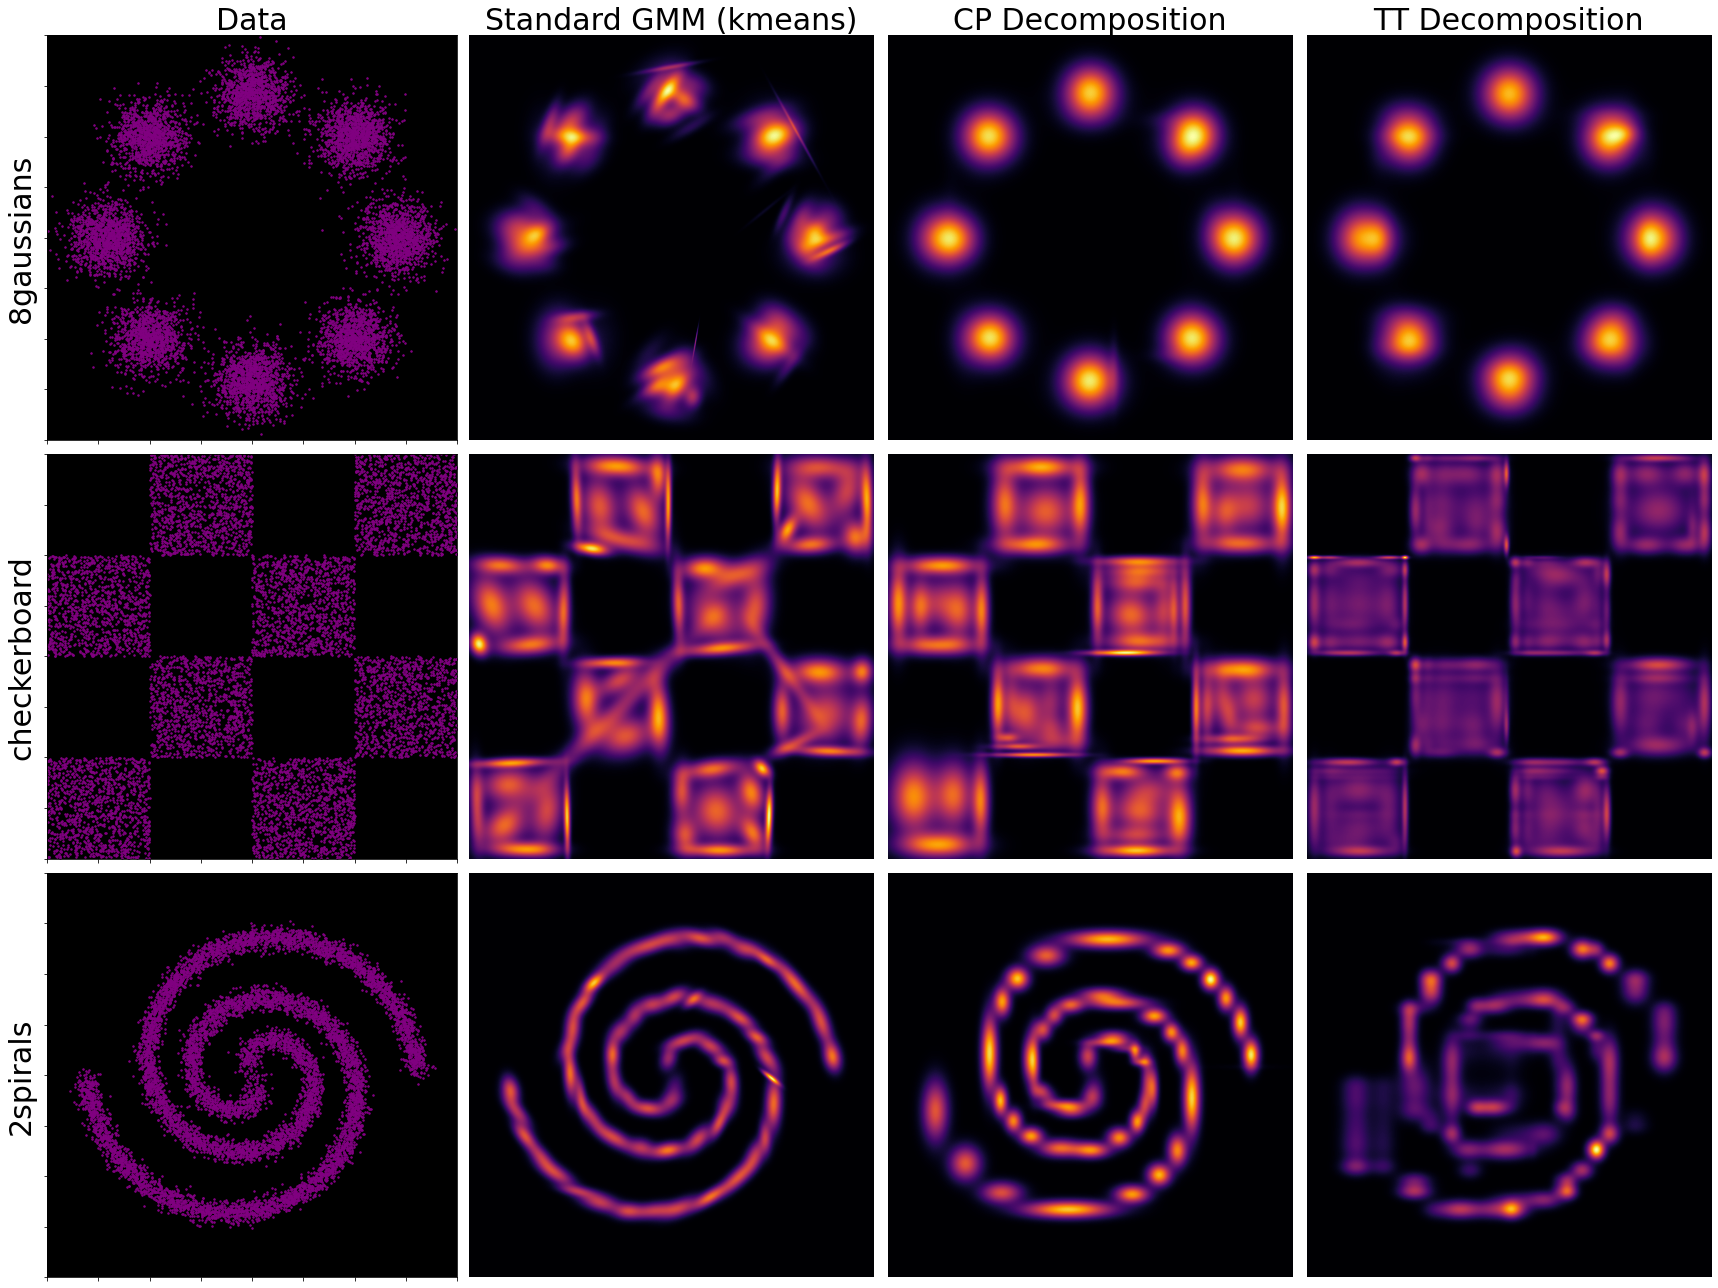

In [14]:
f,ax = plt.subplots(3, 4, figsize=(24, 18))

# Plot data
ax[0, 0].plot(data_1[:, 0], data_1[:, 1], '.', c=col, ms=mark_size)
ax[1, 0].plot(data_2[:, 0], data_2[:, 1], '.', c=col, ms=mark_size)
ax[2, 0].plot(data_3[:, 0], data_3[:, 1], '.', c=col, ms=mark_size)

for i in range(3):
    ax[i, 0].set_xlim((-4, 4))
    ax[i, 0].set_ylim((-4, 4))
    ax[i, 0].patch.set_facecolor('black')
    ax[i, 0].set_yticklabels([])
    ax[i, 0].set_xticklabels([])


# density plot for GMM 'random'
# utl.plot_density(ax[0, 1], model_gmm_1, cmap=color_map, cbar=cbar, axis=False, gmm=True)
# utl.plot_density(ax[1, 1], model_gmm_2, cmap=color_map, cbar=cbar, axis=False, gmm=True)
# utl.plot_density(ax[2, 1], model_gmm_3, cmap=color_map, cbar=cbar, axis=False, gmm=True)

# density plot for GMM 'kmeans'
utl.plot_density(ax[0, 1], model_gmm_1_km, cmap=color_map, cbar=cbar, axis=False, gmm=True)
utl.plot_density(ax[1, 1], model_gmm_2_km, cmap=color_map, cbar=cbar, axis=False, gmm=True)
utl.plot_density(ax[2, 1], model_gmm_3_km, cmap=color_map, cbar=cbar, axis=False, gmm=True)

# density plot for CP
utl.plot_density(ax[0, 2], model_cp_1, cmap=color_map, cbar=cbar, axis=False)
utl.plot_density(ax[1, 2], model_cp_2, cmap=color_map, cbar=cbar, axis=False)
utl.plot_density(ax[2, 2], model_cp_3, cmap=color_map, cbar=cbar, axis=False)

# density plot for TT
utl.plot_density(ax[0, 3], model_tt_1, cmap=color_map, cbar=cbar, axis=False)
utl.plot_density(ax[1, 3], model_tt_2, cmap=color_map, cbar=cbar, axis=False)
utl.plot_density(ax[2, 3], model_tt_3, cmap=color_map, cbar=cbar, axis=False)


# Titles
ax[0, 0].set_title('Data', fontsize=font_size, color=font_clr)
# ax[0, 1].set_title('Standard GMM (rand)', fontsize=font_size, color=font_clr)
ax[0, 1].set_title('Standard GMM', fontsize=font_size, color=font_clr)
ax[0, 2].set_title('CP Decomposition', fontsize=font_size, color=font_clr)
ax[0, 3].set_title('TT Decomposition', fontsize=font_size, color=font_clr)

# row 'titles'
ax[0, 0].set_ylabel('8gaussians', fontsize=font_size, color=font_clr)
ax[1, 0].set_ylabel('checkerboard', fontsize=font_size, color=font_clr)
ax[2, 0].set_ylabel('2spirals', fontsize=font_size, color=font_clr)

f.tight_layout()
plt.savefig('../figures/gaussian_comparison_2d.png')
plt.show()